## Import dependencies


In [106]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt

import seaborn as sns

## Read data

In [107]:
X_train = pd.read_csv("../data/train_test_val/X_train.csv", header=[0,1], index_col=0)
X_test = pd.read_csv("../data/train_test_val/X_test.csv", header=[0,1], index_col=0)
X_val = pd.read_csv("../data/train_test_val/X_val.csv", header=[0,1], index_col=0)

y_train = pd.read_csv("../data/train_test_val/y_train.csv", index_col=0) 
y_val = pd.read_csv("../data/train_test_val/y_val.csv", index_col=0)
y_test = pd.read_csv("../data/train_test_val/y_test.csv", index_col=0)

### Creating ML Pipeline

In [108]:
rfc = RandomForestClassifier(random_state=42)
svc = SVC(random_state=42)
knc = KNeighborsClassifier()
abc = AdaBoostClassifier(random_state=42)
gbc = GradientBoostingClassifier(random_state=42)
gnb = GaussianNB()
lr = LogisticRegressionCV(max_iter=1000, random_state=42)

models = {"rfc": rfc,"svc": svc, "knc" : knc,
          "abc" : abc, "gbc" : gbc, "gnb" :gnb,
          "lr": lr}

In [109]:
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train.drop("id_gps", axis=1)) 
scaled_X_val = scaler.fit_transform(X_val.drop("id_gps", axis=1))
scaled_X_test = scaler.fit_transform(X_test.drop("id_gps", axis=1))

c:\users\mesza\.virtualenvs\road-surface-quality-7nv9hwjf\lib\site-packages\pandas\core\generic.py:3878: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
c:\users\mesza\.virtualenvs\road-surface-quality-7nv9hwjf\lib\site-packages\pandas\core\generic.py:3878: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
c:\users\mesza\.virtualenvs\road-surface-quality-7nv9hwjf\lib\site-packages\pandas\core\generic.py:3878: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [110]:
X_train = X_train.drop("id_gps", axis = 1)
X_val = X_val.drop("id_gps", axis = 1)
X_test = X_test.drop("id_gps", axis = 1)
y_train = y_train.values.reshape(-1)
y_val = y_val.values.reshape(-1)
y_test = y_test.values.reshape(-1)


c:\users\mesza\.virtualenvs\road-surface-quality-7nv9hwjf\lib\site-packages\pandas\core\generic.py:3878: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


Accuracy Score rfc: 0.8556
Accuracy Score svc: 0.8380
Accuracy Score knc: 0.8521
Accuracy Score abc: 0.8239
Accuracy Score gbc: 0.8627
Accuracy Score gnb: 0.8169
Accuracy Score lr: 0.8873


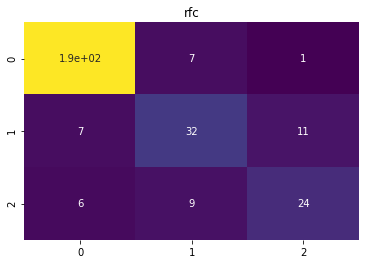

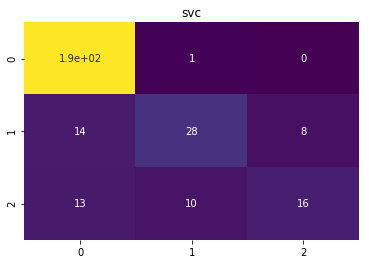

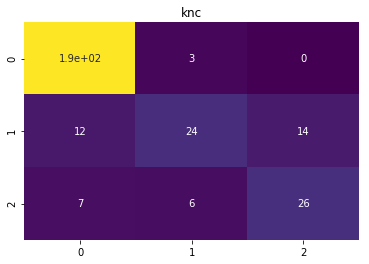

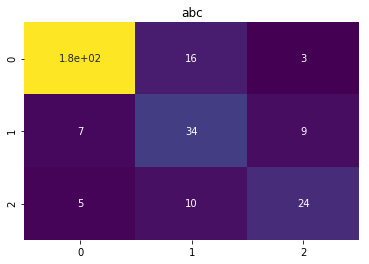

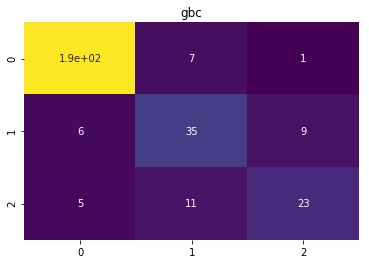

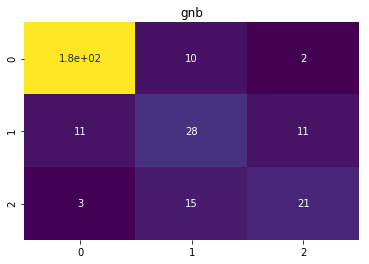

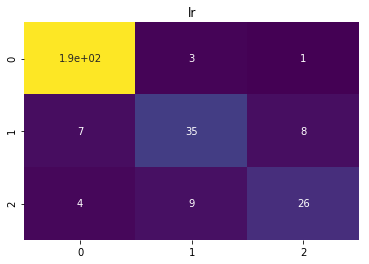

In [111]:
for m in models:
    
    model = models[m].fit(scaled_X_train, y_train)
    preds = model.predict(scaled_X_val)
    accuracy = accuracy_score(y_val, preds)
    
    print("Accuracy Score {}: {:.4f}".format(m,accuracy))
    cm = confusion_matrix(y_val,preds)
    
    fig = plt.figure()
    fig = plt.title(m)
    sns.heatmap(cm, cmap="viridis", annot= True, cbar = False)

The best results belongs to the RandomForest Classifier, but the KNC results are promising as well.

#### Logistic Regression

In [112]:
lr.fit(scaled_X_train, y_train)

LogisticRegressionCV(max_iter=1000, random_state=42)

## Hyperparameter tuning

In [113]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

In [ ]:
params = {
        "min_samples_leaf": [1,2,3 ,4, 8,16,20],
        "min_samples_split": [2, 4, 8, 12],
        "n_estimators": [100, 400, 800,1200]
}

rfc_search = RandomizedSearchCV(rfc, 
                                params, 
                                n_iter=36,
#                                 average = "weighted",
                                scoring="recall_weighted",
                                random_state=42)

rfc_search.fit(scaled_X_train, y_train)

In [114]:
# best_model = rfc_search.best_estimator_
preds = lr.predict(scaled_X_val)
accuracy = accuracy_score(y_val,preds)
precision = precision_score(y_val,preds,average="weighted")
recall = recall_score(y_val,preds, average="weighted")
f1 = f1_score(y_val, preds, average="weighted")

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.8873239436619719
Precision: 0.882347391702225
Recall: 0.8873239436619719
F1 Score: 0.884225779738773


### Cross Validation

In [98]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix

In [99]:
cv = cross_validate(lr,
               X =  scaled_X_test,
               y = np.ravel(y_test))

print("Model accuracy is {:.2f}±{:.2f}".format(cv["test_score"].mean()*100,cv["test_score"].std()*100))

Model accuracy is 87.92±4.90


In [100]:
cm = confusion_matrix(y_val,preds)

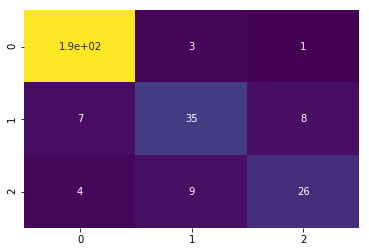

In [101]:
sns.heatmap(cm, cmap="viridis", annot= True, cbar = False)

## Save the model

In [103]:
from joblib import dump, load
dump(lr, '../models/lr_v08.joblib') 

['../models/rfc_v08.joblib']